In [1]:
import numpy as np
from casadi import *

# E, O2, EO, H2O, CO2, N2
molar_masses = np.array([28.05, 32, 44.05, 18, 44.01, 28]) * 1e-3  # kg / mol
x_in = np.array([0.1, 0.08, 0.0001, 0.0025, 0.08, 0.7374])
x_var = SX.sym("x", len(x_in))
xi = SX.sym("xi", 2)
n = SX.sym("n", 2)
initial = np.array([1, 1, 1, 1])

f = x_var.T @ molar_masses
A = x_var * n[1] - x_in * n[0]
b = vertcat(
    *[-xi[0] - xi[1], -0.5 * xi[0] - 3 * xi[1], xi[0], 2 * xi[1], 2 * xi[1], 0]
)
g = vertcat(*[sum(x_var) - 1, n[0] - n[1] + 0.5 * xi[0], A - b])

nlp = {"f": f, "x": vertcat(x_var, n, xi), "g": g}
opts = {"ipopt.print_level": 0}
sol = nlpsol("solver", "ipopt", nlp, opts)

res = sol(lbg=0, ubg=0, lbx=0, x0=vertcat(x_in, initial))

display(res["x"])
display(res["f"])

display("Delta x: ", res["x"][:6] - x_in)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 109.00us (832.06ns)  99.59us (760.21ns)       131
       nlp_g  | 164.00us (  1.25us) 131.62us (  1.00us)       131
  nlp_grad_f  |  51.00us (  1.19us)  41.50us (965.05ns)        43
  nlp_hess_l  |  42.00us (  1.05us)  31.29us (782.27ns)        40
   nlp_jac_g  |  50.00us (  1.14us)  45.62us (  1.04us)        44
       total  |  20.41ms ( 20.41ms)  21.53ms ( 21.53ms)         1


DM([0.0734163, 0.000248998, 0.0001, 0.0556673, 0.133167, 0.7374, 65532.5, 65532.5, 1.85767e-08, 1742.1])

DM(0.0295816)

'Delta x: '

DM([-0.0265837, -0.079751, 2.83459e-13, 0.0531673, 0.0531673, -1.04472e-13])

In [2]:
n0 = 1000  # mol
nE_in = n0 * x_in[0]
C = np.array(
    [
        [21.07, 82.76],
        [27.73, 7.68],
        [20.14, 110.45],
        [29.74, 10.95],
        [31.01, 27.27],
        [27.08, 5.65],
    ]
)  # heat capacity coefficients cp [J mol-1 K-1]


def coeffs(xi1, xi2):
    return np.array(
        [
            (-xi1 - xi2 + x_in[0] * n0) / (n0 - 0.5 * xi1),
            (-0.5 * xi1 - 3 * xi2 + x_in[1] * n0) / (n0 - 0.5 * xi1),
            (xi1 + x_in[2] * n0) / (n0 - 0.5 * xi1),
            (2 * xi2 + x_in[3] * n0) / (n0 - 0.5 * xi1),
            (2 * xi2 + x_in[4] * n0) / (n0 - 0.5 * xi1),
            (x_in[5] * n0) / (n0 - 0.5 * xi1),
        ]
    )


def M_tot(xi1, xi2):
    A = coeffs(xi1, xi2)
    return np.tensordot(molar_masses.squeeze(), A, axes=([0], [0]))


def cp_tot(xi1, xi2, T):
    A = coeffs(xi1, xi2)
    T_vec = np.array([1, T / 1000])
    cp_i = C @ T_vec
    return np.tensordot(cp_i.squeeze(), A, axes=([0], [0]))


cp_tot(0, 20, 300)

array(31.603015)

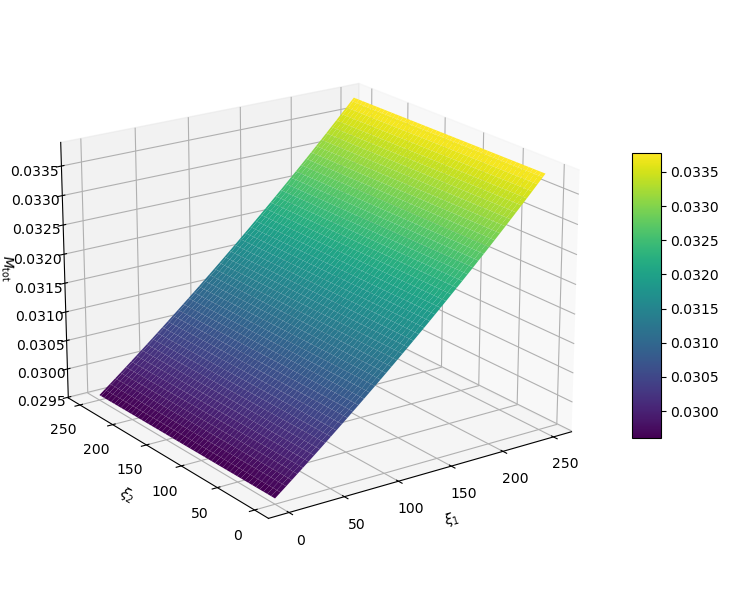

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xi1 = np.linspace(0, 250, 100)
xi2 = np.linspace(0, 250, 100)
XI1, XI2 = np.meshgrid(xi1, xi2)
Z = M_tot(XI1, XI2)  # deine Funktion wird hier auf das Gitter angewendet

# Plot erstellen
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(XI1, XI2, Z, cmap="viridis", edgecolor="none")

# Achsentitel
ax.set_xlabel(r"$\xi_1$")
ax.set_ylabel(r"$\xi_2$")
ax.set_zlabel(r"$M_\text{tot}$")

# Farbskala anzeigen
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.view_init(elev=20, azim=235)
plt.tight_layout()
plt.show()

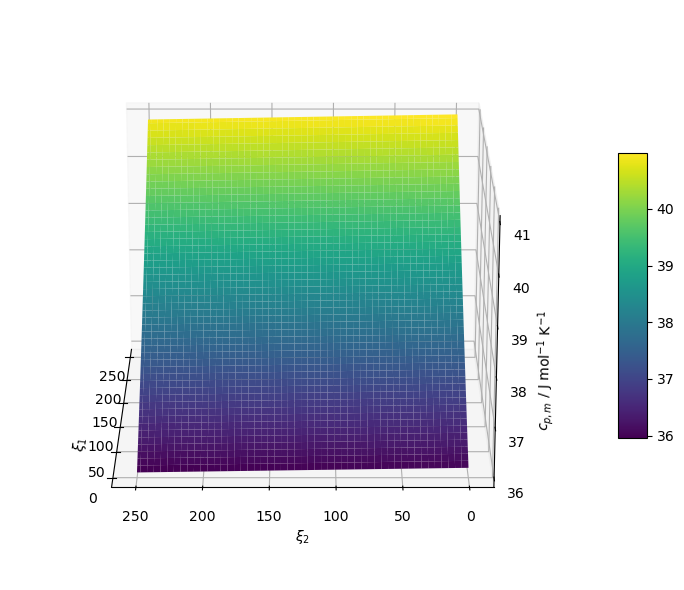

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xi1 = np.linspace(0, 250, 100)
xi2 = np.linspace(0, 250, 100)
XI1, XI2 = np.meshgrid(xi1, xi2)
Z = cp_tot(XI1, XI2, 600)  # deine Funktion wird hier auf das Gitter angewendet

# Plot erstellen
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(XI1, XI2, Z, cmap="viridis", edgecolor="none")

# Achsentitel
ax.set_xlabel(r"$\xi_1$")
ax.set_ylabel(r"$\xi_2$")
ax.set_zlabel(r"$c_{p,m}$ / J mol$^{-1}$ K$^{-1}$")

# Farbskala anzeigen
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.view_init(elev=20, azim=180)
plt.tight_layout()
plt.show()

In [12]:
# enthalpies of formation at T=600K
# E, O2, EO, H2O, CO2
nu = np.array([
    [-1, -0.5, 1, 0, 0],
    [-1, -3, 0, 2, 2]]
) # stoichiometric coefficients of the components for both reactions
Coeff_matrix = np.array(
    [
        [-6.387880, 184.4019, -112.9718, 28.49593, 0.315540, 48.17332, 52.46694],
        [31.32234, -20.23531, 57.86644, -36.50624, -0.007374, -8.903471, 0.0],
        [-23.25802, 275.6997 , -188.9729 ,  51.0335 ,   0.38693, -55.09156, -52.63514],
        [30.09200, 6.832514, 6.793435, -2.534480, 0.082139, -250.8810, -241.8264],
        [24.99735, 55.18696, -33.69137, 7.948387, -0.136638, -403.6075, -393.5224]

    ]
)  #  A*t + B*t2/2 + C*t3/3 + D*t4/4 − E/t + F − H
h0_comp = np.array([52.47, 0, -52.64, -241.83, -393.52])  # at reference temperature 298.15 K

def calculate_h_comp(T: float):
    """reference is T = 298.15 K"""
    t = T / 1000
    T_vec = np.array([t, 0.5 * t**2, t**3/3, t**4/4, - 1/t, 1, -1])
    delta_h = Coeff_matrix @ T_vec
    return delta_h + h0_comp


h_comp = calculate_h_comp(600)
dHr = nu @ h_comp

print("h_component at 600 K [kJ/mol]: ", h_comp.round(2))
print("dH_R at 600 K [kJ/mol]: ", dHr)

h_component at 600 K [kJ/mol]:  [  69.8     9.24  -32.02 -231.33 -380.61]
dH_R at 600 K [kJ/mol]:  [ -106.44384962 -1321.41572614]
